In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from natsort import natsort_keygen

import statsmodels.api as sm
import scipy as sp

import rpy2.rinterface
import os
import sys

from statsmodels.stats.proportion import proportion_confint

# Need to specify your R lib here
os.environ['R_HOME'] = os.path.join(sys.exec_prefix, 'lib/R') # e.g. '/Users/Gneiss/opt/miniconda3/envs/numpyro1/lib/R'

In [2]:
%load_ext rpy2.ipython

/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
%%R
Sys.setenv(LANG = "en")

# Load WWTP data

In [4]:
# This requires Pandas >=1.0
df = pd.read_csv('data/tallymut_line_snv4.tsv', sep='\t', parse_dates=['date'])

df['mutation'] = df['pos'].astype(str) + df['base']

df_wide = (
    df[(~df['plantname'].isna()) & (df['date'] >= '2020-12-08') & (df['base'] != '-') & (df['B.1.1.7'] == "mut")]
    .pivot(index=['plantname', 'date', 'batch'], columns=['mutation'], values='frac')
    .sort_index(axis=1, key=natsort_keygen())
)

df_wide_cov = (
    df[(~df['plantname'].isna()) & (df['date'] >= '2020-12-08') & (df['base'] != '-') & (df['B.1.1.7'] == "mut")]
    .pivot(index=['plantname', 'date', 'batch'], columns=['mutation'], values='cov')
    .sort_index(axis=1, key=natsort_keygen())
)

df_wide_counts = (
    df[(~df['plantname'].isna()) & (df['date'] >= '2020-12-08') & (df['base'] != '-') & (df['B.1.1.7'] == "mut")]
    .pivot(index=['plantname', 'date', 'batch'], columns=['mutation'], values='var')
    .sort_index(axis=1, key=natsort_keygen())
)

## Make counts wide df

In [5]:
ZHdf_cov = df_wide_cov.loc['Zürich (ZH)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
ZHdf_cov = ZHdf_cov.T.groupby("date").agg("mean").asfreq('D').T

ZHdf_counts = df_wide_counts.loc['Zürich (ZH)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
ZHdf_counts = ZHdf_counts.T.groupby("date").agg("mean").asfreq('D').T

VDdf_cov = df_wide_cov.loc['Lausanne (VD)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
VDdf_cov = VDdf_cov.T.groupby("date").agg("mean").asfreq('D').T

VDdf_counts = df_wide_counts.loc['Lausanne (VD)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
VDdf_counts = VDdf_counts.T.groupby("date").agg("mean").asfreq('D').T

## Load cantonal viollier data and aggregate by week

In [6]:
viollier2 = pd.read_csv("data/data_per_day_and_canton2.csv")
viollier2["date"] = pd.DatetimeIndex(viollier2["date"])
viollier2["week"] = viollier2.date.dt.strftime('%W')
viollier2["year"] = viollier2.date.dt.strftime('%Y')
viollier2["date_week"] = pd.to_datetime(viollier2["year"].astype(str), format='%Y') +\
    pd.to_timedelta(((viollier2["week"].astype("int")-1).mul(7)+3-7).astype(str) + ' days')

viollier2_sum = viollier2.groupby(["date_week", "canton"], as_index=False).agg("sum")
viollier2_sum["frac_b117"] = viollier2_sum["b117"] / viollier2_sum["sequenced"]
viollier2_sum["p_pseudo"] = (viollier2_sum["b117"] + 1) / (viollier2_sum["sequenced"] + 2)
viollier2_sum["error"] = 1.96*np.sqrt(viollier2_sum["p_pseudo"]*(1-viollier2_sum["p_pseudo"])/(viollier2_sum["sequenced"]+2))

In [7]:
gisaid_data = pd.read_csv("data/gisaid_seq_2021_05_04.csv")
gisaid_data = gisaid_data[gisaid_data.originating_lab == "Viollier AG"]
gisaid_data["b117"] = (gisaid_data.pangolin_lineage == "B.1.1.7")

gisaid_data_agg = pd.concat([gisaid_data[["date", "division", "pangolin_lineage"]].groupby(["date", "division"]).agg("count"),
           gisaid_data[["date", "division", "b117"]].groupby(["date", "division"]).agg("sum")],
          axis=1)
gisaid_data_agg = gisaid_data_agg.reset_index()

gisaid_data_agg["date"] = pd.DatetimeIndex(gisaid_data_agg["date"])
gisaid_data_agg["week"] = gisaid_data_agg.date.dt.strftime('%W')
gisaid_data_agg["year"] = gisaid_data_agg.date.dt.strftime('%Y')
gisaid_data_agg["date_week"] = pd.to_datetime(gisaid_data_agg["year"].astype(str), format='%Y') +\
    pd.to_timedelta(((gisaid_data_agg["week"].astype("int")-1).mul(7)+3-7).astype(str) + ' days')

In [8]:
canton_names = {
"Zürich" : "ZH",
"Bern" : "BE", 
"Lucerne" : "LU",
"Uri" : "UR",
"Schwyz" : "SZ",
"Obwalden" : "OW",
"Nidwalden" : "NW",
"Glarus" : "GL",
"Zug" : "ZG",
"Fribourg" : "FR",
"Solothurn" : "SO",
"Basel-Stadt" : "BS",
"Basel-Land" : "BL",
"Schaffhausen" : "SH",
"Appenzell Ausserrhoden" : "AR",
"Appenzell Innerrhoden" : "AI",
"Sankt Gallen" : "SG",
"Graubünden" : "GR",
"Aargau" : "AG",
"Thurgau" : "TG",
"Ticino" : "TI",
"Vaud" : "VD",
"Valais" : "VS",
"Neuchâtel" : "NE",
"Geneva" : "GE",
"Jura" : "JU"
}

In [9]:
gisaid_data_agg = gisaid_data_agg[gisaid_data_agg.division != "Switzerland"]
gisaid_data_agg["canton"] = gisaid_data_agg["division"].apply(lambda x: canton_names[x])
gisaid_data_agg = gisaid_data_agg.rename({"pangolin_lineage" : "sequenced"}, axis=1)
gisaid_data_agg

,date,division,sequenced,b117,week,year,date_week,canton
0,2020-03-04,Graubünden,1,0,09,2020,2020-02-22,GR
1,2020-03-04,Ticino,1,0,09,2020,2020-02-22,TI
2,2020-03-05,Basel-Land,2,0,09,2020,2020-02-22,BL
3,2020-03-05,Basel-Stadt,1,0,09,2020,2020-02-22,BS
4,2020-03-05,Graubünden,2,0,09,2020,2020-02-22,GR
...,...,...,...,...,...,...,...,...
3256,2021-04-15,Thurgau,1,1,15,2021,2021-04-05,TG
3257,2021-04-15,Valais,3,3,15,2021,2021-04-05,VS
3258,2021-04-15,Vaud,2,2,15,2021,2021-04-05,VD
3259,2021-04-15,Zug,1,1,15,2021,2021-04-05,ZG


In [10]:
viollier2 = gisaid_data_agg

## Prepare data

###  ZH wastewater

In [11]:
ZHyy_ww = np.array([ZHdf_counts.sum(axis=0).values, (ZHdf_cov.sum(axis=0) - ZHdf_counts.sum(axis=0)).values]).T
ZHxx_ww = (ZHdf_cov.T.index - np.datetime64('2020-12-14')) / np.timedelta64(1, 'D')
ZHxx_ww = sm.add_constant(ZHxx_ww)

ZHxx_ww = ZHxx_ww[np.sum(ZHyy_ww, 1) != 0, :] #remove timepoints with 0 observations
ZHyy_ww = ZHyy_ww[np.sum(ZHyy_ww, 1) != 0, :]


###  ZH clinical

In [12]:
viollier2["wt"] = viollier2["sequenced"] - viollier2["b117"]

ZHyy_clinical = viollier2[(viollier2["canton"] == "ZH") & (viollier2["date"].isin(ZHdf_cov.T.index))][["b117", "wt"]].values

ZHxx_clinical = (viollier2[(viollier2["canton"] == "ZH") & (viollier2["date"].isin(ZHdf_cov.T.index))].date - np.datetime64('2020-12-14')) / np.timedelta64(1, 'D')
ZHxx_clinical = sm.add_constant(ZHxx_clinical).values

# ZHxx_clinical = ZHxx_clinical[np.sum(ZHyy_clinical, 1) != 0,:] #remove timepoints with 0 observations
# ZHyy_clinical = ZHyy_clinical[np.sum(ZHyy_clinical, 1) != 0,:]


###  VD wastewater

In [13]:
VDyy_ww = np.array([VDdf_counts.sum(axis=0).values, (VDdf_cov.sum(axis=0) - VDdf_counts.sum(axis=0)).values]).T
VDxx_ww = (VDdf_cov.T.index - np.datetime64('2020-12-14')) / np.timedelta64(1, 'D')
VDxx_ww = sm.add_constant(VDxx_ww)

VDxx_ww = VDxx_ww[np.sum(VDyy_ww, 1) != 0, :] #remove timepoints with 0 observations
VDyy_ww = VDyy_ww[np.sum(VDyy_ww, 1) != 0, :]

### Model VD clinical

In [14]:
viollier2["wt"] = viollier2["sequenced"] - viollier2["b117"]

VDyy_clinical = viollier2[(viollier2["canton"] == "VD") & (viollier2["date"].isin(VDdf_cov.T.index))][["b117", "wt"]].values

VDxx_clinical = (viollier2[(viollier2["canton"] == "VD") & (viollier2["date"].isin(VDdf_cov.T.index))].date - np.datetime64('2020-12-14')) / np.timedelta64(1, 'D')
VDxx_clinical = sm.add_constant(VDxx_clinical).values

# VDxx_clinical = VDxx_clinical[np.sum(VDyy_clinical, 1) != 0,:] #remove timepoints with 0 observations
# VDyy_clinical = VDyy_clinical[np.sum(VDyy_clinical, 1) != 0,:]

# Make logistic quasibinomial regression 

In [15]:
sys.setrecursionlimit(9000)
#sys.getrecursionlimit()

In [16]:
%%R -i ZHxx_ww -i ZHyy_ww -o glm_ZH_ww_pred2

x <- ZHxx_ww[,2]
glm_ZH_ww_r2 <- glm(ZHyy_ww ~ x, family="quasibinomial")

# do prediction interval in the link scale and then logit them
pred_link <- predict(glm_ZH_ww_r2, newdata=data.frame(x=min(x):(max(x)+2)),type="link", se.fit=T)
upp <- pred_link$fit + 1.96*pred_link$se.fit
low <- pred_link$fit - 1.96*pred_link$se.fit

glm_ZH_ww_pred2 <- lapply(list(pred_link$fit, low, upp) ,glm_ZH_ww_r2$family$linkinv)
names(glm_ZH_ww_pred2) <- as.character(1:length(glm_ZH_ww_pred2))

In [17]:
%%R -i ZHxx_clinical -i ZHyy_clinical -o glm_ZH_clinical_pred2

x <- ZHxx_clinical[,2]
glm_ZH_clinical_r2 <- glm(ZHyy_clinical ~ x, family="quasibinomial")

# do prediction interval in the link scale and then logit them
pred_link <- predict(glm_ZH_clinical_r2, newdata=data.frame(x=min(x):(max(x)+2)),type="link", se.fit=T)
upp <- pred_link$fit + 1.96*pred_link$se.fit
low <- pred_link$fit - 1.96*pred_link$se.fit

glm_ZH_clinical_pred2 <- lapply(list(pred_link$fit, low, upp) ,glm_ZH_clinical_r2$family$linkinv)
names(glm_ZH_clinical_pred2) <- as.character(length(glm_ZH_clinical_pred2))

In [18]:
%%R -i VDxx_ww -i VDyy_ww -o glm_VD_ww_pred2

x <- VDxx_ww[,2]
glm_VD_ww_r2 <- glm(VDyy_ww ~ x, family="quasibinomial")

# do prediction interval in the link scale and then logit them
pred_link <- predict(glm_VD_ww_r2, newdata=data.frame(x=min(x):(max(x))),type="link", se.fit=T)
upp <- pred_link$fit + 1.96*pred_link$se.fit
low <- pred_link$fit - 1.96*pred_link$se.fit

glm_VD_ww_pred2 <- lapply(list(pred_link$fit, low, upp) ,glm_VD_ww_r2$family$linkinv)
names(glm_VD_ww_pred2) <- as.character(length(glm_VD_ww_pred2))

In [19]:
%%R -i VDxx_clinical -i VDyy_clinical -o glm_VD_clinical_pred2

x <- VDxx_clinical[,2]
glm_VD_clinical_r2 <- glm(VDyy_clinical ~ x, family="quasibinomial")

# do prediction interval in the link scale and then logit them
pred_link <- predict(glm_VD_clinical_r2, newdata=data.frame(x=(-6):(max(x))),type="link", se.fit=T)
upp <- pred_link$fit + 1.96*pred_link$se.fit
low <- pred_link$fit - 1.96*pred_link$se.fit

glm_VD_clinical_pred2 <- lapply(list(pred_link$fit, low, upp) ,glm_VD_clinical_r2$family$linkinv)
names(glm_VD_clinical_pred2) <- as.character(length(glm_VD_clinical_pred2))

In [20]:
# cast R output as a Python list of list
glm_ZH_ww_pred2 = [list(i) for i in glm_ZH_ww_pred2]
glm_ZH_clinical_pred2 = [list(i) for i in glm_ZH_clinical_pred2]
glm_VD_ww_pred2 = [list(i) for i in glm_VD_ww_pred2]
glm_VD_clinical_pred2 = [list(i) for i in glm_VD_clinical_pred2]

## Make plots of logistic regression

/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/statsmodels/stats/proportion.py:89: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/statsmodels/stats/proportion.py:134: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1 + crit2 / nobs
/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in true_divide
  center = (q_ + crit2 / (2 * nobs)) / denom
/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in true_divide
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))
/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/statsmodels/stats/proportion.py:89: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/home/dryak/miniconda3/envs/rp

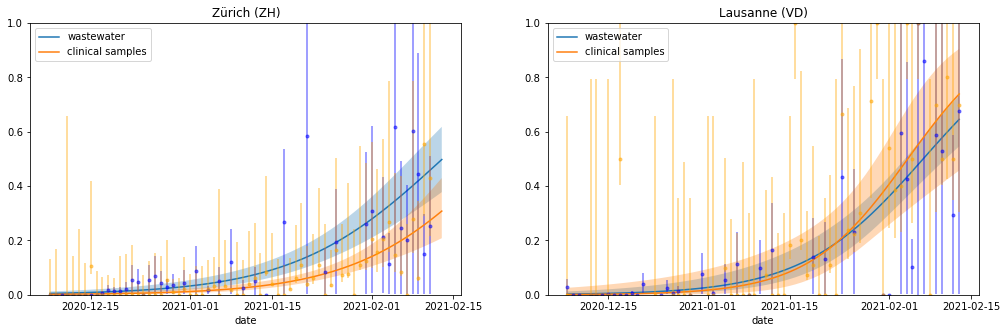

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5))

sns.lineplot(
    x = VDdf_cov.T.index,
    y = glm_ZH_ww_pred2[0],
    ax=axes[0], label="wastewater"
    )
axes[0].fill_between(VDdf_cov.T.index,
                     glm_ZH_ww_pred2[1],
                     glm_ZH_ww_pred2[2],
                     alpha=.3)
axes[0].errorbar(
    x=ZHdf_cov.T.index, 
    y=ZHdf_counts.sum() / ZHdf_cov.sum(), 
    yerr=proportion_confint(ZHdf_counts.sum(), ZHdf_cov.sum(), alpha=0.05, method="wilson"),
    fmt=".", color="blue", alpha=0.5
)


sns.lineplot(
    x = VDdf_cov.T.index,
    y = glm_ZH_clinical_pred2[0],
    ax=axes[0], label="clinical samples"
    )
axes[0].fill_between(VDdf_cov.T.index,
                     glm_ZH_clinical_pred2[1],
                     glm_ZH_clinical_pred2[2],
                     alpha=.3)
ZHyy_clinical2 = viollier2[(viollier2["canton"] == "ZH") & (viollier2["date"].isin(ZHdf_cov.T.index))][["b117", "wt"]]
axes[0].errorbar(
    x=ZHxx_clinical[:,1]*np.timedelta64(1, 'D') + np.datetime64('2020-12-14'), 
    y=ZHyy_clinical2["b117"] / (ZHyy_clinical2["b117"]+ZHyy_clinical2["wt"]),
    yerr=proportion_confint(ZHyy_clinical2["b117"],
                            (ZHyy_clinical2["b117"]+ZHyy_clinical2["wt"]),
                            alpha=0.05, method="wilson"),
    fmt=".", color="orange", alpha=0.5
)

axes[0].legend(loc='upper left')
axes[0].set_title("Zürich (ZH)")
axes[0].set_ylim((0,1))

sns.lineplot(
    x = VDdf_cov.T.index,
    y = glm_VD_ww_pred2[0],
    ax=axes[1], label="wastewater"
    )
axes[1].fill_between(VDdf_cov.T.index,
                     glm_VD_ww_pred2[1],
                     glm_VD_ww_pred2[2],
                     alpha=.3)
axes[1].errorbar(
    x=VDdf_cov.T.index, 
    y=VDdf_counts.sum() / VDdf_cov.sum(), 
    yerr=proportion_confint(VDdf_counts.sum(), VDdf_cov.sum(), alpha=0.05, method="wilson"),
    fmt=".", color="blue", alpha=0.5
)

sns.lineplot(
    x = VDdf_cov.T.index,
    y = glm_VD_clinical_pred2[0],
    ax=axes[1], label="clinical samples"
    )
axes[1].fill_between(VDdf_cov.T.index,
                     glm_VD_clinical_pred2[1],
                     glm_VD_clinical_pred2[2],
                     alpha=.3)
VDyy_clinical2 = viollier2[(viollier2["canton"] == "VD") & (viollier2["date"].isin(VDdf_cov.T.index))][["b117", "wt"]]
axes[1].errorbar(
    x=VDxx_clinical[:,1]*np.timedelta64(1, 'D') + np.datetime64('2020-12-14'), 
    y=VDyy_clinical2["b117"] / (VDyy_clinical2["b117"]+VDyy_clinical2["wt"]),
    yerr=proportion_confint(VDyy_clinical2["b117"],
                            VDyy_clinical2["b117"]+VDyy_clinical2["wt"],
                            alpha=0.05, method="wilson"),
    fmt=".", color="orange", alpha=0.5
)

axes[1].legend(loc='upper left')
axes[1].set_title("Lausanne (VD)")
axes[1].set_ylim((0,1))

plt.savefig("plots/logist_plot2.pdf")
plt.show()

### Confints with overdispersion

In [22]:
%%R

coefs <- lapply(list(glm_ZH_clinical_r2, glm_ZH_ww_r2, glm_VD_clinical_r2, glm_VD_ww_r2), function(x){
    rbind(c(coef(x)[2], confint(x)[2,]))
})
coefs <- Reduce(function(...) rbind.data.frame(...), coefs)
row.names(coefs) <- c("ZH clinical", "ZH wastewater", "VD clinical", "VD wastewater")
colnames(coefs)[1] = "growth rate"
round(coefs, 2)

/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Waiting for profiling to be done...

  warnings.warn(x, RRuntimeWarning)


              growth rate 2.5 % 97.5 %
ZH clinical          0.08  0.06   0.11
ZH wastewater        0.08  0.06   0.10
VD clinical          0.12  0.06   0.19
VD wastewater        0.10  0.07   0.13


### Confint fitness_d

In [23]:
%%R
fitness_discr <- function(a){exp(a*4.8)-1}
fitness_discr <- fitness_discr(coefs)
colnames(fitness_discr)[1] <- "fitness d."
round(fitness_discr, 2)

              fitness d. 2.5 % 97.5 %
ZH clinical         0.49  0.34   0.68
ZH wastewater       0.46  0.35   0.60
VD clinical         0.76  0.34   1.47
VD wastewater       0.59  0.42   0.84


### Confint fitness_d for Chen et al: redo with backtransformation from logit space


In [24]:
fitness_discr = lambda x: np.exp(x*4.8)-1
print("Zürich Region")
print([round(i,2) for i in (fitness_discr(0.07), fitness_discr(0.11))])
print("Lake Geneva Region")
print([round(i,2) for i in (fitness_discr(0.09), fitness_discr(0.14))])

Zürich Region
[0.4, 0.7]
Lake Geneva Region
[0.54, 0.96]


# Do online fitness estimation: vary time series length

## Prepare Data

In [25]:
# make one df with all I need
viollier2["wt"] = viollier2["sequenced"] - viollier2["b117"]
viollier2.index = viollier2.date

# make ZH ww df
ZHwwdf = pd.DataFrame({"b117": ZHdf_counts.sum(axis=0),
                       "wt": (ZHdf_cov.sum(axis=0) - ZHdf_counts.sum(axis=0))})
# make ZH clinical df
ZHclinicaldf = viollier2[(viollier2["canton"] == "ZH") & (viollier2["date"].isin(ZHdf_cov.T.index))][["b117", "wt"]]

# make VD ww df
VDwwdf = pd.DataFrame({"b117": VDdf_counts.sum(axis=0),
                       "wt": (VDdf_cov.sum(axis=0) - VDdf_counts.sum(axis=0))})

# make VD clinical df
VDclinicaldf = viollier2[(viollier2["canton"] == "VD") & (viollier2["date"].isin(VDdf_cov.T.index))][["b117", "wt"]]



Count_df = pd.concat([ZHwwdf, ZHclinicaldf, VDwwdf, VDclinicaldf], axis=1)
Count_df.set_axis(["ZH_ww_b117", "ZH_ww_wt", "ZH_clinical_b117", "ZH_clinical_wt",
                   "VD_ww_b117", "VD_ww_wt", "VD_clinical_b117", "VD_clinical_wt"], axis = 1, inplace=True)
Count_df["day"] = np.arange(Count_df.shape[0])
Count_array = Count_df.values

Please ignore error message in next cell

In [27]:
%%R -i Count_df
# This cell will throw an error because some attributes fail to be passed between python and R,
# no worries just keep executing the next cells
# would require Pandas<=0.25.3, but <=1.0 is required (see above)
1

AttributeError: type object 'DataFrame' has no attribute 'from_items'

## Fit online models

In [28]:
%%R -o All_est_mat -o All_est_mat_names
All_est <- lapply(6:68, function(i){
    ZH_wwfit = glm(as.matrix(Count_df[1:i,c("ZH_ww_b117", "ZH_ww_wt")]) ~ Count_df$day[1:i], family="quasibinomial",
                  start=c(-6,0.1))
    ZH_clinfit = glm(as.matrix(Count_df[1:i,c("ZH_clinical_b117", "ZH_clinical_wt")]) ~ Count_df$day[1:i], family="quasibinomial",
                    start=c(-6,0.1))
    VD_wwfit = glm(as.matrix(Count_df[1:i,c("VD_ww_b117", "VD_ww_wt")]) ~ Count_df$day[1:i], family="quasibinomial",
                  start=c(-6,0.1))
    VD_clinfit = glm(as.matrix(Count_df[1:i,c("VD_clinical_b117", "VD_clinical_wt")]) ~ Count_df$day[1:i], family="quasibinomial",
                    start=c(-6,0.1))

    coefs <- lapply(list(ZH_wwfit, ZH_clinfit, VD_wwfit, VD_clinfit), function(x){
        rbind(c(coef(x)[2], coef(x)[2] + c(-1, 1) * 1.96 * summary(x)$coefficients[2,2]))
    })
    coefs <- Reduce(function(...) cbind.data.frame(...), coefs)
    colnames(coefs) <- paste0(rep(c("ZH", "VD"), each=6), "_",
                              rep(c("ww", "clinical"), each=3), "_",
                              rep(c("estimate", "q025", "q975"), times=4))
    return(coefs)
})
All_est_df <- Reduce(function(...) rbind(...), All_est)
All_est_mat <- as.matrix(All_est_df)
All_est_mat_names <- colnames(All_est_df)

In [29]:
All_est_df = pd.DataFrame(np.array(All_est_mat))
All_est_df.set_axis(All_est_mat_names, axis=1, inplace=True)
All_est_df.set_axis(Count_df.index[5:], axis=0, inplace=True)


# Load city data

In [30]:
viollier3 = pd.read_csv("data/data_per_city_short.csv")
viollier3
viollier3["date"] = pd.DatetimeIndex(viollier3["date"])
viollier3["week"] = viollier3.date.dt.strftime('%W')
viollier3["year"] = viollier3.date.dt.strftime('%Y')
viollier3["date_week"] = pd.to_datetime(viollier3["year"].astype(str), format='%Y') +\
    pd.to_timedelta(((viollier3["week"].astype("int")-1).mul(7)+3-7).astype(str) + ' days')

viollier3_sum = viollier3.groupby(["date_week", "city"], as_index=False).agg("sum")
viollier3_sum["frac_b117"] = viollier3_sum["b117"] / viollier3_sum["sequenced"]
viollier3_sum["p_pseudo"] = (viollier3_sum["b117"] + 1) / (viollier3_sum["sequenced"] + 2)
viollier3_sum["error"] = 1.96*np.sqrt(viollier3_sum["p_pseudo"]*(1-viollier3_sum["p_pseudo"])/(viollier3_sum["sequenced"]+2))

In [31]:
# Prepare ZH city data

viollier3["wt"] = viollier3["sequenced"] - viollier3["b117"]
ZHyy_clinical_city = viollier3[(viollier3["city"] == "Zürich") & (viollier3["date"].isin(ZHdf_cov.T.index))][["b117", "wt"]].values

ZHxx_clinical_city = (viollier3[(viollier3["city"] == "Zürich") & (viollier3["date"].isin(ZHdf_cov.T.index))]["date"] - np.datetime64('2020-12-14')) / np.timedelta64(1, 'D')
ZHxx_clinical_city = sm.add_constant(ZHxx_clinical_city)
ZHxx_clinical_city = ZHxx_clinical

# Prepare VD city data

VDyy_clinical_city = viollier3[(viollier3["city"] == "Lausanne") & (viollier3["date"].isin(ZHdf_cov.T.index))][["b117", "wt"]].values

VDxx_clinical_city = (viollier3[(viollier3["city"] == "Lausanne") & (viollier3["date"].isin(ZHdf_cov.T.index))]["date"] - np.datetime64('2020-12-14')) / np.timedelta64(1, 'D')
VDxx_clinical_city = sm.add_constant(VDxx_clinical_city)
VDxx_clinical_city = VDxx_clinical_city

## Vary series length 

In [32]:
# make one df with all I need
viollier3["wt"] = viollier3["sequenced"] - viollier3["b117"]
viollier3.index = viollier3.date

# make ZH ww df
ZHwwdf = pd.DataFrame({"b117": ZHdf_counts.sum(axis=0),
                       "wt": (ZHdf_cov.sum(axis=0) - ZHdf_counts.sum(axis=0))})
# make ZH clinical df
ZHclinicaldf_city = viollier3[(viollier3["city"] == "Zürich") & (viollier3["date"].isin(ZHdf_cov.T.index))][["b117", "wt"]]

# make VD ww df
VDwwdf = pd.DataFrame({"b117": VDdf_counts.sum(axis=0),
                       "wt": (VDdf_cov.sum(axis=0) - VDdf_counts.sum(axis=0))})




Count_df2 = pd.concat([ZHwwdf, ZHclinicaldf_city, VDwwdf], axis=1)
Count_df2.set_axis(["ZH_ww_b117", "ZH_ww_wt", "ZH_clinical_b117", "ZH_clinical_wt",
                   "VD_ww_b117", "VD_ww_wt"], axis = 1, inplace=True)
Count_df2["day"] = np.arange(Count_df2.shape[0])
Count_array2 = Count_df2.values

Please ignore error message in next cell

In [33]:
%%R -i Count_df2
# This cell will throw an error because some attributes fail to be passed between python and R,
# no worries just keep executing the next cells
# would require Pandas<=0.25.3, but <=1.0 is required (see above)
1

AttributeError: type object 'DataFrame' has no attribute 'from_items'

In [34]:
%%R -o ZHclincitydf1
ZHclincitydf1 <- lapply(10:68, function(i){
    mod <- glm(as.matrix(Count_df2[1:i,c("ZH_clinical_b117", "ZH_clinical_wt")]) ~ Count_df2$day[1:i], family="quasibinomial",
                    start=c(-6,0.1))
    rbind(c(coef(mod)[2], coef(mod)[2] + c(-1, 1) * 1.96 * summary(mod)$coefficients[2,2]))
})
ZHclincitydf1 <- Reduce(function(...) rbind(...), ZHclincitydf1)
ZHclincitydf1 <- as.matrix(ZHclincitydf1)

# Do different versions of online estimate plot

In [35]:
def fitness_discr(a, g=4.8):
    return np.exp(a*g)-1

/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dryak/miniconda3/envs/rpy2/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


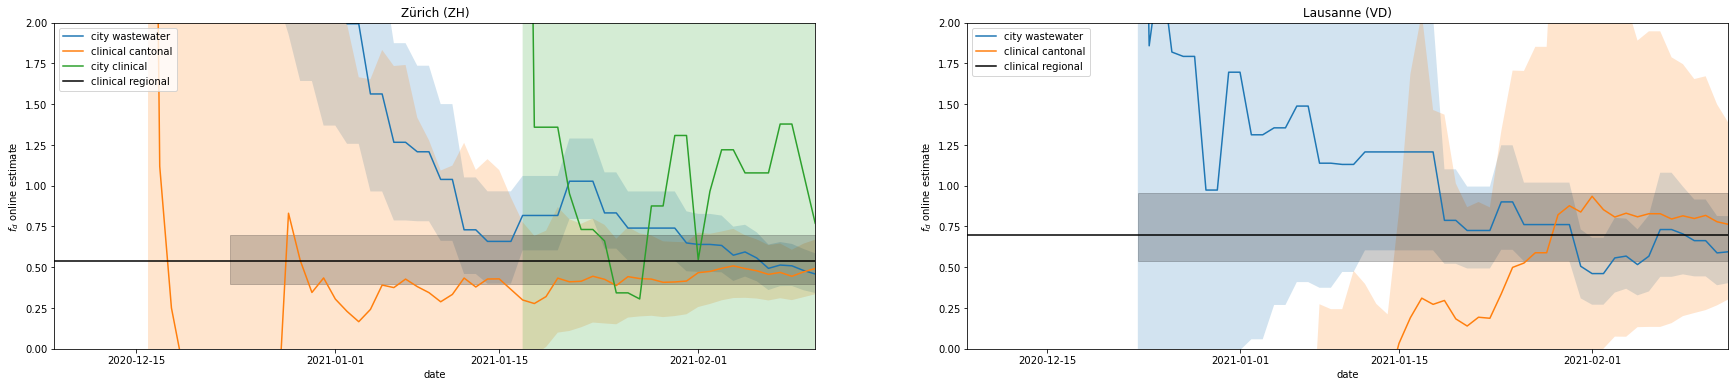

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 6))

sns.lineplot(x=All_est_df.index[All_est_df.index>np.datetime64("2020-12-22")],
             y=fitness_discr(All_est_df["ZH_ww_estimate"][All_est_df.index>np.datetime64("2020-12-22")]),
             ax=axes[0], 
             label="city wastewater")
axes[0].fill_between(All_est_df.index[All_est_df.index>np.datetime64("2020-12-22")], 
                       fitness_discr(All_est_df["ZH_ww_q025"][All_est_df.index>np.datetime64("2020-12-22")]),
                       fitness_discr(All_est_df["ZH_ww_q975"][All_est_df.index>np.datetime64("2020-12-22")]),
                       alpha=.2)

# axes[0].axhline(np.array(ZHclincitydf1)[-1:,0], linestyle="--", color="orange")
# axes[0].axhline(np.array(ZHclincitydf1)[-1:,1], linestyle=":", color="orange")
# axes[0].axhline(np.array(ZHclincitydf1)[-1:,2], linestyle=":", color="orange")

sns.lineplot(x=All_est_df.index[All_est_df.index > np.datetime64('2020-12-14')],
             y=fitness_discr(All_est_df["ZH_clinical_estimate"][All_est_df.index > np.datetime64('2020-12-14')]),
             ax=axes[0],
             label="clinical cantonal")
axes[0].fill_between(All_est_df.index[All_est_df.index > np.datetime64('2020-12-14')], 
                       fitness_discr(All_est_df["ZH_clinical_q025"][All_est_df.index > np.datetime64('2020-12-14')]),
                       fitness_discr(All_est_df["ZH_clinical_q975"][All_est_df.index > np.datetime64('2020-12-14')]),
                       alpha=.2)

sns.lineplot(x=Count_df2.index[-28:],
             y=fitness_discr(np.array(ZHclincitydf1)[-28:,0]),
             ax=axes[0],
             label="city clinical")
axes[0].fill_between(Count_df2.index[-28:],
                     fitness_discr(np.array(ZHclincitydf1)[-28:,1]),
                     fitness_discr(np.array(ZHclincitydf1)[-28:,2]),
                     alpha=.2)

axes[0].axhline(fitness_discr(0.09), linestyle="-", color="black", label="clinical regional")
# axes[0].axhline(fitness_discr(0.07), linestyle=":", color="black")
# axes[0].axhline(fitness_discr(0.11), linestyle=":", color="black")
axes[0].fill_between(All_est_df.index[All_est_df.index>np.datetime64("2020-12-22")], 
                     fitness_discr(0.07),
                     fitness_discr(0.11), color="black", alpha=.2)




### Lausanne

sns.lineplot(x=All_est_df.index[All_est_df.index>np.datetime64("2020-12-22")],
             y=fitness_discr(All_est_df["VD_ww_estimate"][All_est_df.index>np.datetime64("2020-12-22")]),
             ax=axes[1], 
             label="city wastewater")
axes[1].fill_between(All_est_df.index[All_est_df.index>np.datetime64("2020-12-22")], 
                       fitness_discr(All_est_df["VD_ww_q025"][All_est_df.index>np.datetime64("2020-12-22")]),
                       fitness_discr(All_est_df["VD_ww_q975"][All_est_df.index>np.datetime64("2020-12-22")]),
                       alpha=.2)

sns.lineplot(x=All_est_df.index[All_est_df.index > np.datetime64('2021-01-04')],
             y=fitness_discr(All_est_df["VD_clinical_estimate"][All_est_df.index > np.datetime64('2021-01-04')]),
             ax=axes[1],
             label="clinical cantonal")
axes[1].fill_between(All_est_df.index[All_est_df.index > np.datetime64('2021-01-04')], 
                       fitness_discr(All_est_df["VD_clinical_q025"][All_est_df.index > np.datetime64('2021-01-04')]),
                       fitness_discr(All_est_df["VD_clinical_q975"][All_est_df.index > np.datetime64('2021-01-04')]),
                       alpha=.2)

axes[1].axhline(fitness_discr(0.11), linestyle="-", color="black", label="clinical regional")
# axes[1].axhline(fitness_discr(0.09), linestyle=":", color="black")
# axes[1].axhline(fitness_discr(0.14), linestyle=":", color="black")
axes[1].fill_between(All_est_df.index[All_est_df.index>np.datetime64("2020-12-22")], 
                     fitness_discr(0.09),
                     fitness_discr(0.14), color="black", alpha=.2)

axes[0].set_ylim((0, 2))
axes[0].set_title("Zürich (ZH)")
axes[0].set_ylabel(r"$f_d$ online estimate")
axes[0].set_xlim((np.datetime64("2020-12-08"), np.datetime64("2021-02-11")))
axes[0].legend(loc='upper left')

axes[1].set_ylim((0, 2))
axes[1].set_xlim((np.datetime64("2020-12-08"), np.datetime64("2021-02-13")))
axes[1].set_title("Lausanne (VD)")
axes[1].set_ylabel(r"$f_d$ online estimate")
axes[1].legend(loc='upper left')
axes[0].set_xticks(["2020-12-15", "2021-01-01", "2021-01-15", "2021-02-01"])
axes[1].set_xticks(["2020-12-15", "2021-01-01", "2021-01-15", "2021-02-01"])

# axes[1].set_xticklabels(rotation=90, ha='center')
# labs1 = axes[1].get_xticklabels
# fig.autofmt_xdate()
plt.savefig("plots/fd_plot1.pdf")

In [37]:
import sys
print(sys.version)
print(sm.__version__)

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]
0.13.2


In [38]:
%%R
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/dryak/miniconda3/envs/rpy2/lib/R/lib/libRblas.so
LAPACK: /home/dryak/miniconda3/envs/rpy2/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] MASS_7.3-51.3  compiler_3.6.1
